In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display
from joblib import dump
from joblib import load

In [4]:
# LOAD DATA HERE

df = pd.read_csv('INSERT FILE PATH HERE!')

print("Data Loaded")

Data Loaded


In [5]:
# Convert track_album_release_date to datetime and extract year
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['album_release_year'] = df['track_album_release_date'].dt.year

# One-hot encoding for playlist_genre and playlist_subgenre
df = pd.get_dummies(df, columns=['playlist_genre', 'playlist_subgenre'])

# Dropping unnecessary columns
df.drop(['track_id', 'track_name', 'track_artist', 'track_album_id', 
         'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id'], 
        axis=1, inplace=True)

print("Changes made")

# Define the features and the target
X = df.drop('track_popularity', axis=1)  # all columns except the target are features
y = df['track_popularity']               # the target variable

# Impute missing values using the median for each column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split the imputed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

print("Successfully split")

Changes made
Successfully split


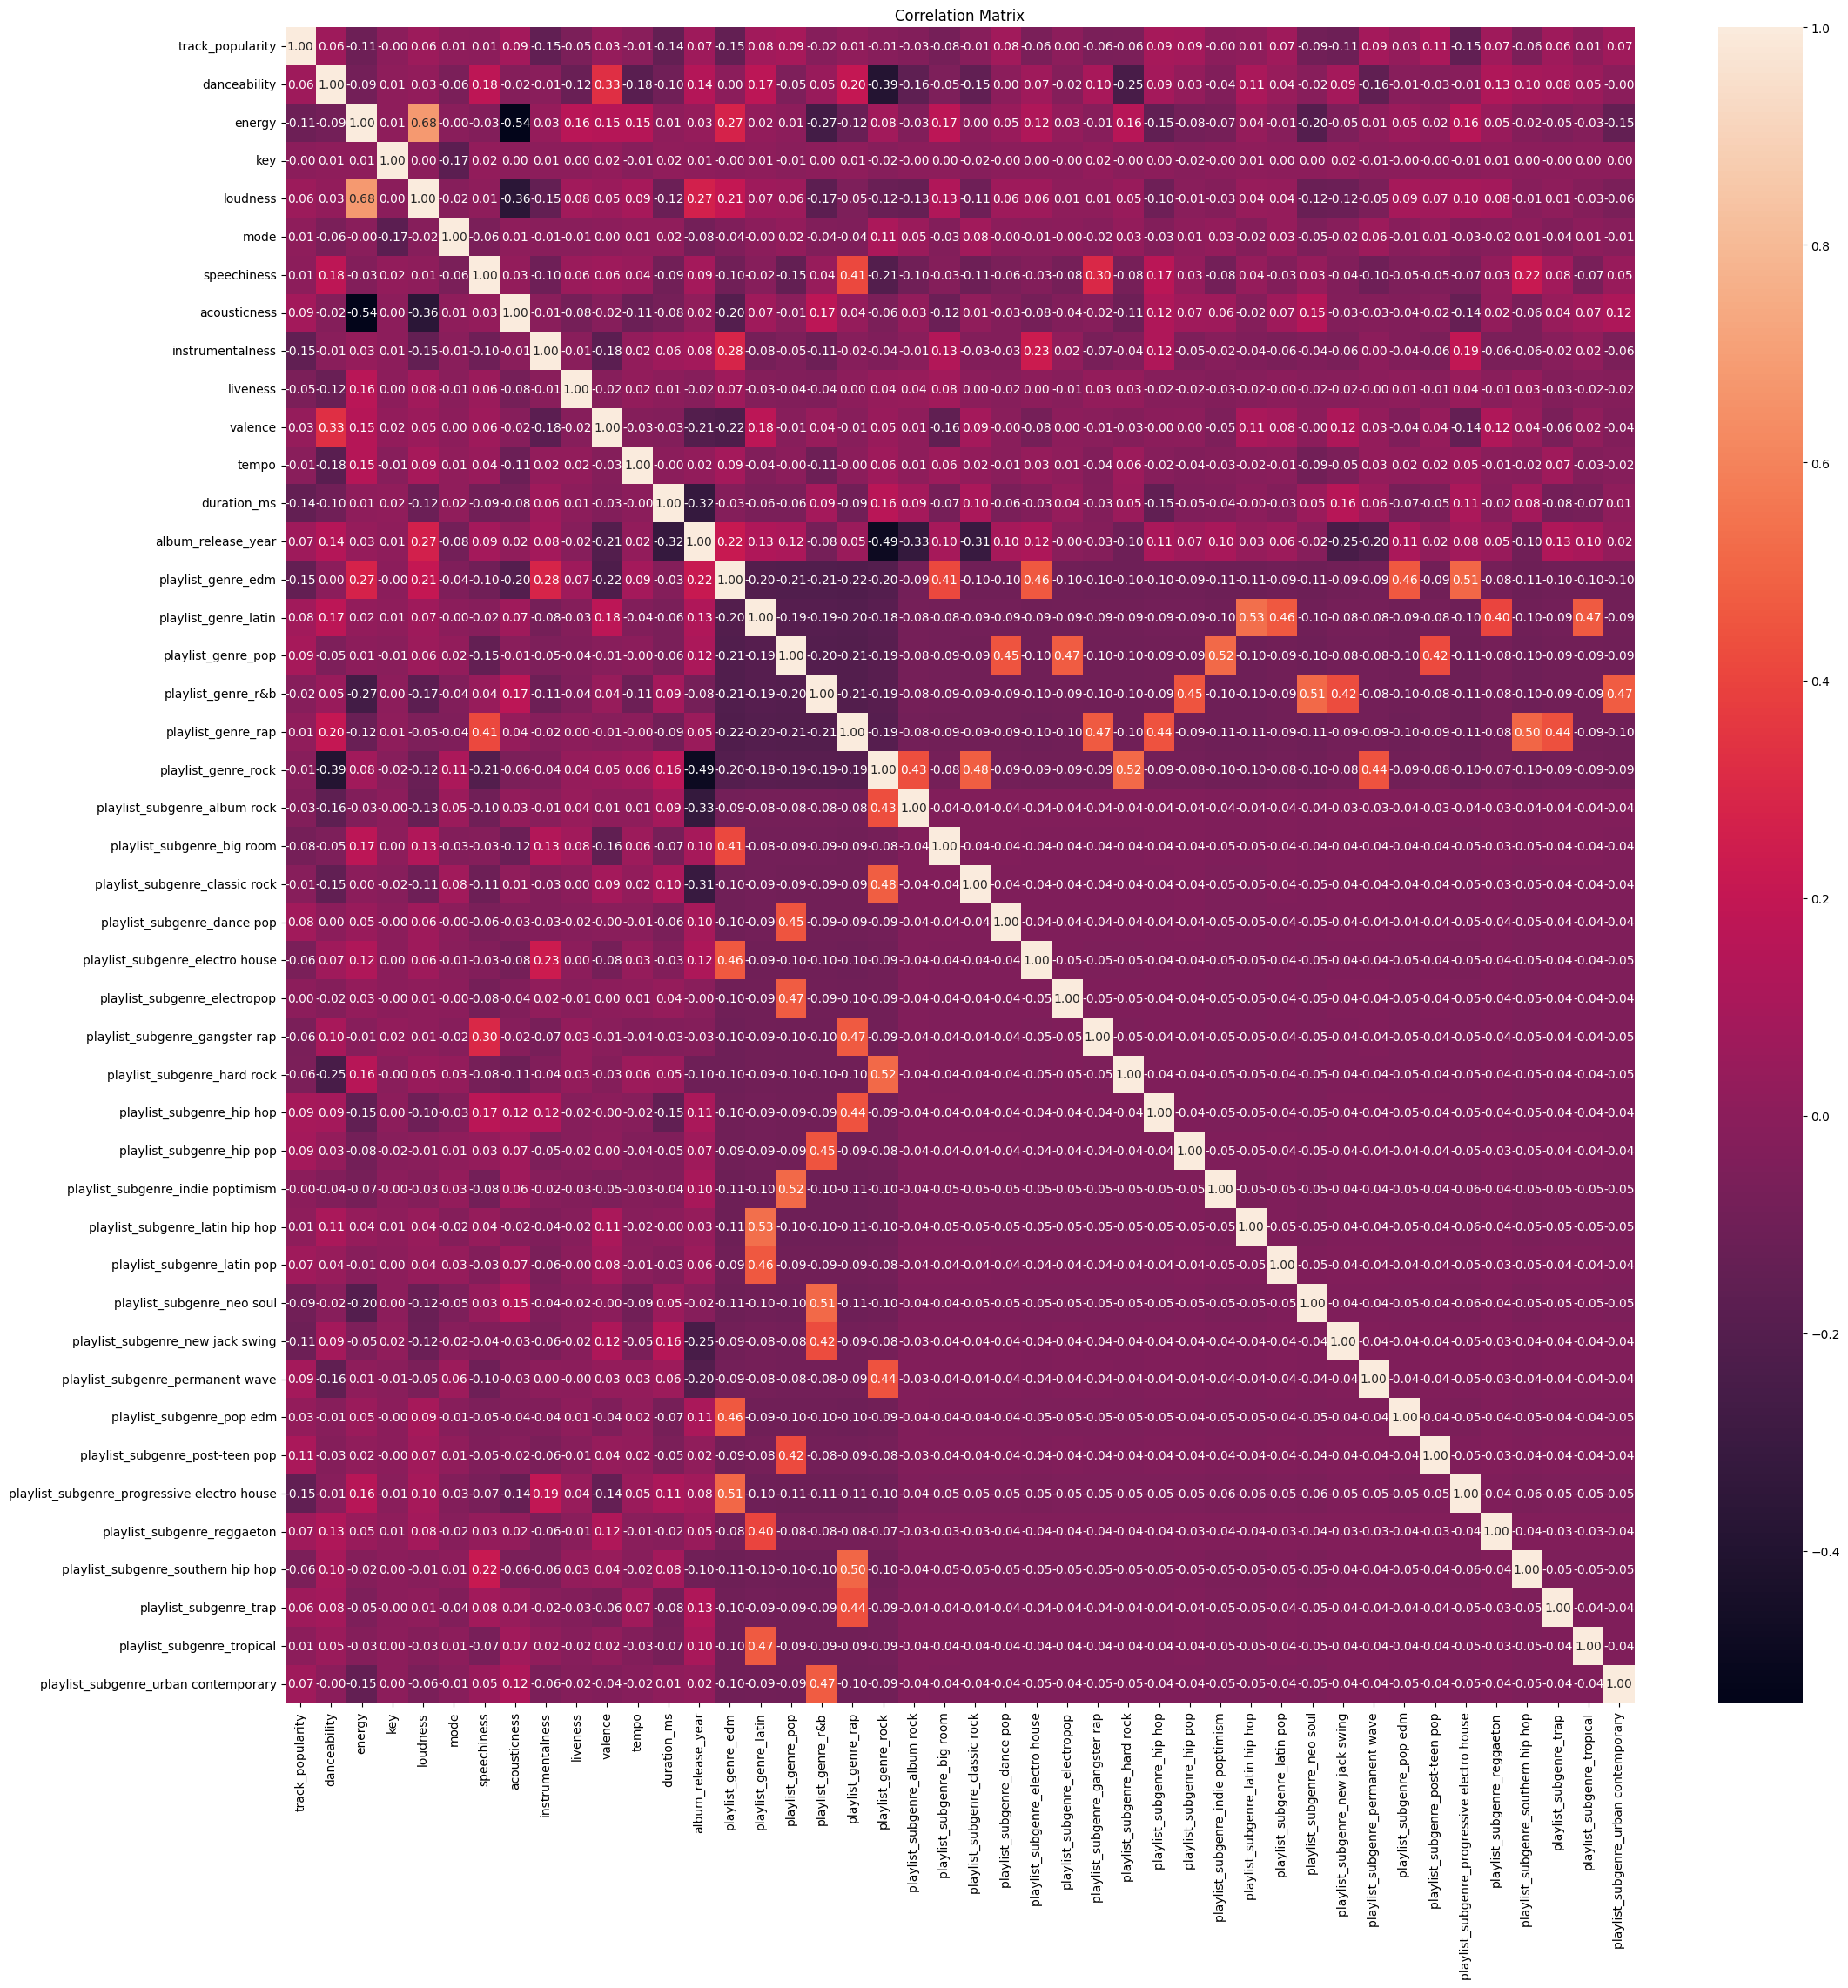

In [6]:
# Correlation Matrix
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

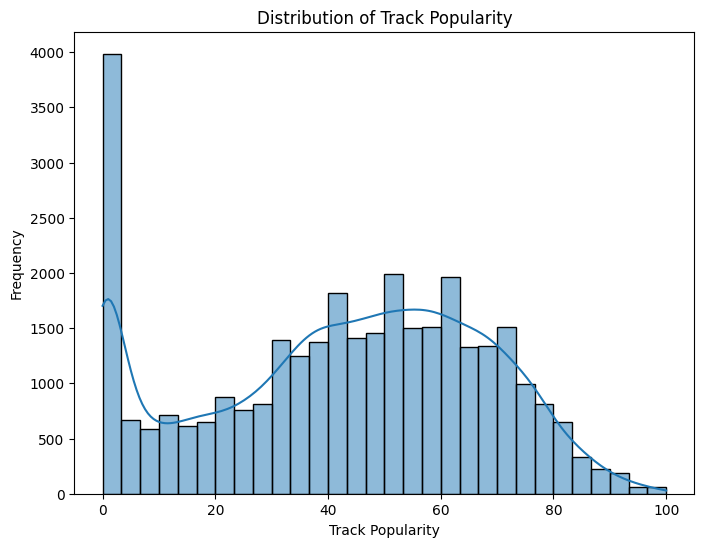

In [7]:
# Distribution Chart
plt.figure(figsize=(8, 6))
sns.histplot(df['track_popularity'], bins=30, kde=True)
plt.title('Distribution of Track Popularity')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.show()


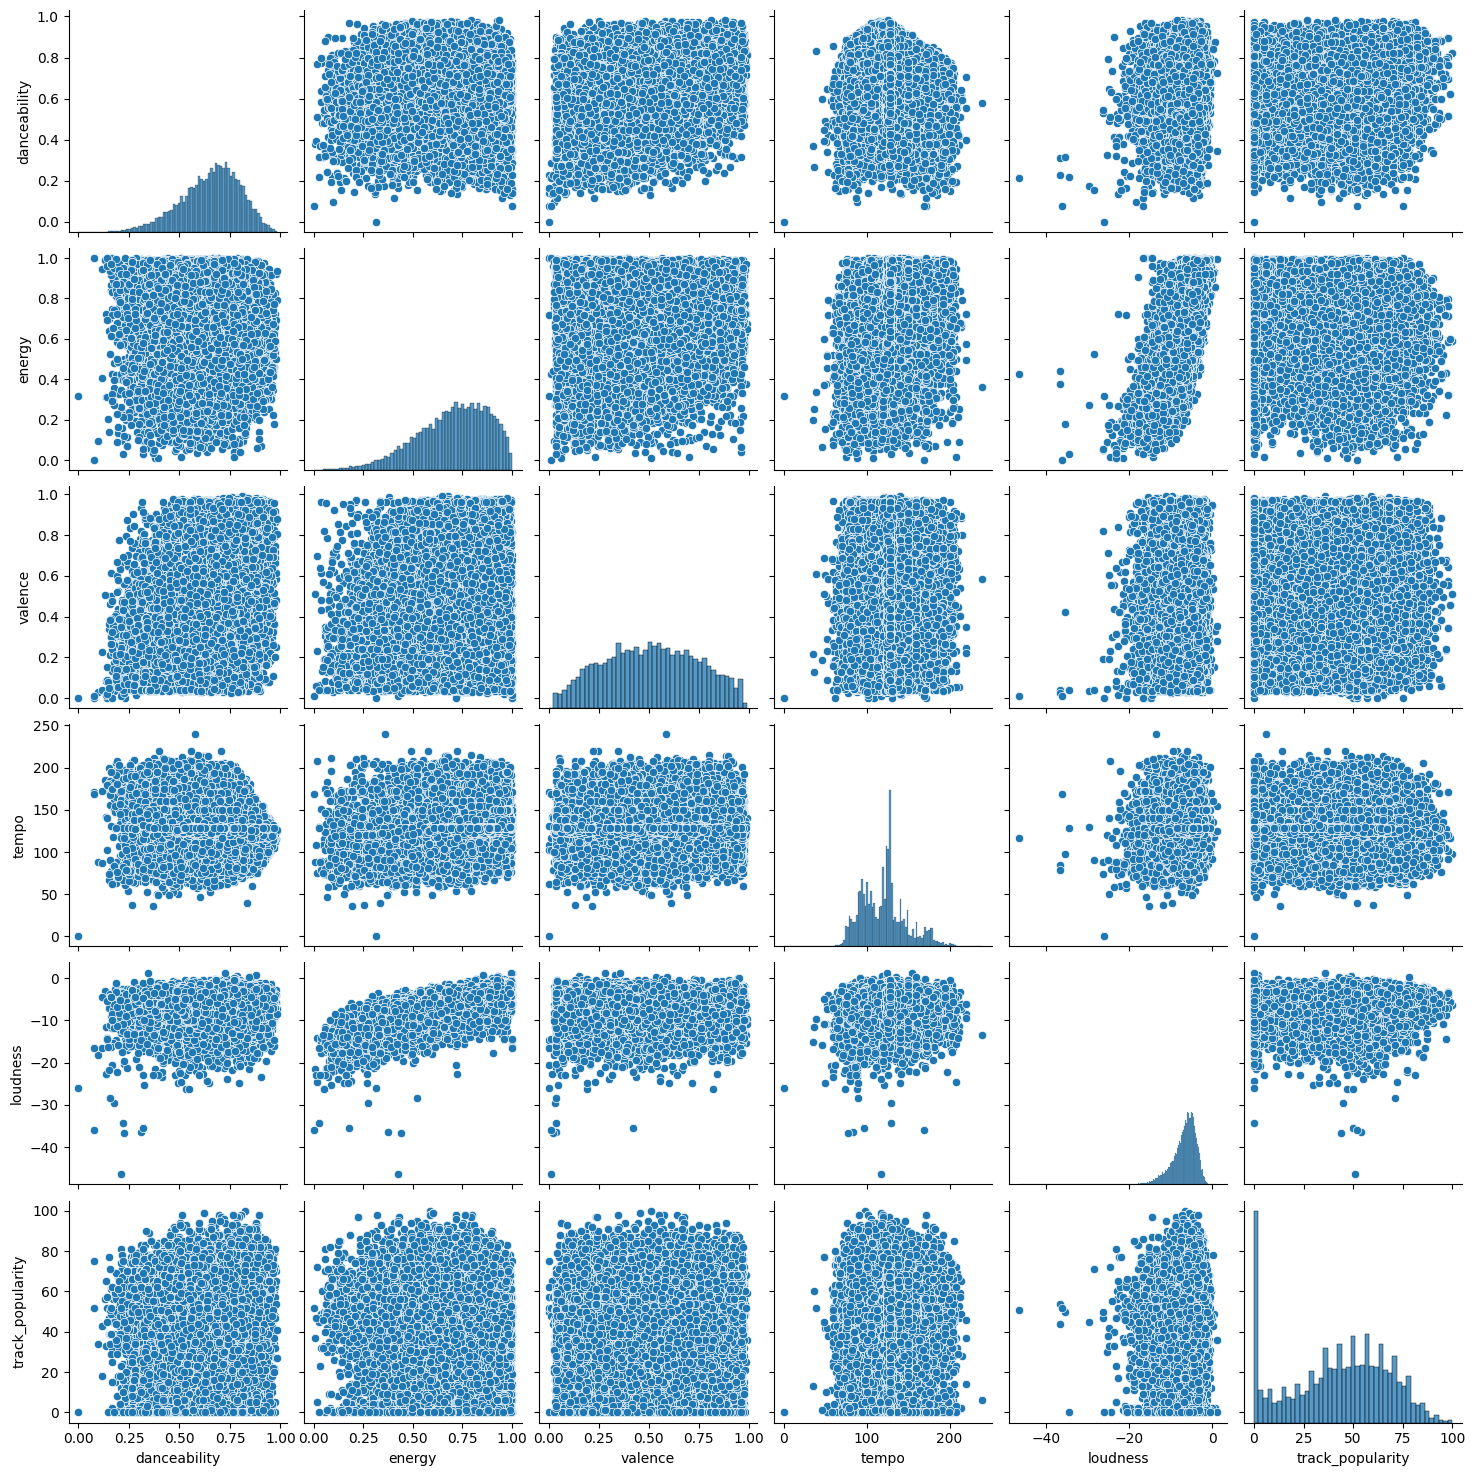

In [8]:
# Pair plot
key_features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'track_popularity']
sns.pairplot(df[key_features])
plt.show()

In [9]:
#Random Forest Model

# Initialize the Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the imputed data
random_forest_model.fit(X_train, y_train)

print("Model Trained")

# Make predictions with the trained model
y_pred = random_forest_model.predict(X_test)

print("Model Predicted")

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')


Model Trained
Model Predicted
Mean Squared Error: 433.9540220311797
Root Mean Squared Error: 20.83156312020727
R-squared: 0.3011231204419116


In [11]:
# Recommendations

# Dropdown for genres
genre_options = df['playlist_genre'].unique().tolist()
genre_dropdown = widgets.Dropdown(
    options=genre_options,
    description='Genre:',
)

recommend_button = widgets.Button(description="Recommend Popular Songs")

# Output area for displaying the recommendations
output_area = widgets.Output()

def on_recommend_button_clicked(b):
    with output_area:
        output_area.clear_output()  # Clear the previous output
        selected_genre = genre_dropdown.value
        # Filter the dataset for the selected genre and sort by popularity
        popular_songs = df[df['playlist_genre'] == selected_genre].sort_values('track_popularity', ascending=False)
        # Display the top 5 songs
        display(popular_songs[['track_name', 'track_artist', 'track_popularity']].head(5))

recommend_button.on_click(on_recommend_button_clicked)

# Display the dropdown, button, and output area
display(genre_dropdown, recommend_button, output_area)


Dropdown(description='Genre:', options=('pop', 'rap', 'rock', 'latin', 'r&b', 'edm'), value='pop')

Button(description='Recommend Popular Songs', style=ButtonStyle())

Output()

In [13]:
# Prediction

# Define the base features
base_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                 'speechiness', 'acousticness', 'instrumentalness', 
                 'liveness', 'valence', 'tempo', 'duration_ms', 'album_release_year']

# Example default values for the base features
# These should be representative values for each feature
default_values = {
    'danceability': 0.5, 'energy': 0.5, 'key': 5, 'loudness': -6.0, 'mode': 1,
    'speechiness': 0.05, 'acousticness': 0.2, 'instrumentalness': 0.0,
    'liveness': 0.15, 'valence': 0.5, 'tempo': 120, 'duration_ms': 200000, 'album_release_year': 2020
}

# Create input widgets for the features
input_widgets = [widgets.FloatText(value=default_values.get(feature, 0.0), description=feature.capitalize(), style={'description_width': 'initial'}) for feature in base_features]

# Dropdowns for genre and subgenre with all possible options
genres = df['playlist_genre'].unique().tolist()
subgenres = df['playlist_subgenre'].unique().tolist()

# Set default values for genre and subgenre dropdowns
genre_widget = widgets.Dropdown(options=genres, description='Genre', value='pop')
subgenre_widget = widgets.Dropdown(options=subgenres, description='Subgenre', value='dance pop')  

# Button for making a prediction
predict_button = widgets.Button(description="Predict Song Popularity", button_style='success')

# Output widget to display the prediction result
output_widget = widgets.Output()

def on_predict_button_clicked(b):
    with output_widget:
        output_widget.clear_output()
        input_feature_values = [widget.value for widget in input_widgets]
        genre = genre_widget.value
        subgenre = subgenre_widget.value

        # Create a DataFrame for the input data
        input_data = pd.DataFrame([input_feature_values], columns=base_features)
        
        # One-hot encode genre and subgenre
        for g in genres:
            input_data['playlist_genre_' + g] = 1 if g == genre else 0
        for sg in subgenres:
            input_data['playlist_subgenre_' + sg] = 1 if sg == subgenre else 0

        # Impute missing values
        imputer = SimpleImputer(strategy='median')
        input_data_imputed = imputer.fit_transform(input_data)

        # Make the prediction
        prediction = random_forest_model.predict(input_data_imputed)
        print(f"Predicted Popularity Score: {prediction[0]}")

# Bind the button click event to the prediction function
predict_button.on_click(on_predict_button_clicked)

# Display the input widgets, predict button, and output widget
for widget in input_widgets + [genre_widget, subgenre_widget]:
    display(widget)
display(predict_button, output_widget)


FloatText(value=0.5, description='Danceability', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.5, description='Energy', style=DescriptionStyle(description_width='initial'))

FloatText(value=5.0, description='Key', style=DescriptionStyle(description_width='initial'))

FloatText(value=-6.0, description='Loudness', style=DescriptionStyle(description_width='initial'))

FloatText(value=1.0, description='Mode', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.05, description='Speechiness', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.2, description='Acousticness', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Instrumentalness', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.15, description='Liveness', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.5, description='Valence', style=DescriptionStyle(description_width='initial'))

FloatText(value=120.0, description='Tempo', style=DescriptionStyle(description_width='initial'))

FloatText(value=200000.0, description='Duration_ms', style=DescriptionStyle(description_width='initial'))

FloatText(value=2020.0, description='Album_release_year', style=DescriptionStyle(description_width='initial'))

Dropdown(description='Genre', options=('pop', 'rap', 'rock', 'latin', 'r&b', 'edm'), value='pop')

Dropdown(description='Subgenre', options=('dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip …

Button(button_style='success', description='Predict Song Popularity', style=ButtonStyle())

Output()